In [158]:
import numpy as np
import math
from math import floor, log, gcd
from qiskit import *
from qiskit.circuit.library import QFT
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

In [159]:
N = 15      # Число, яке факторизуємо
a = 2       # Число, взаємно просте з N

num_target = floor(log(N - 1, 2)) + 1  # Кількість кубітів у target-регістрі
num_control = 2 * num_target  # Кількість кубітів у control-регістрі

# Обчислення a^(2^k) mod N
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a
    
# Список значень a^(2^k) mod N для кожного керуючого кубіта
k_list = range(num_control)
b_list = [a2kmodN(a, k, N) for k in k_list]
print(b_list)

[2, 4, 1, 1, 1, 1, 1, 1]


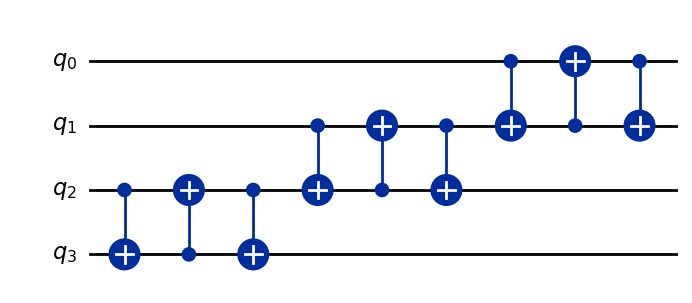

In [160]:
# Унітарний оператор множення на 2 mod 15
def M2mod15():
    U = QuantumCircuit(4)
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
    U = U.to_gate(label="M_2")
    return U

# M2 оператор
M2 = M2mod15()

# Візуалізація оператора M2
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)


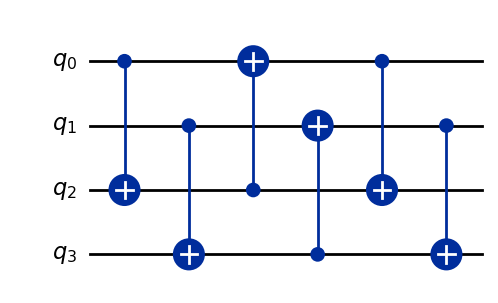

In [161]:
# Унітарний оператор множення на 4 mod 15
def M4mod15():
    U = QuantumCircuit(4)
    U.swap(1, 3)
    U.swap(0, 2)
    U = U.to_gate(label="M_4")
    return U
    

# M4 оператор
M4 = M4mod15()

# Візуалізація оператора M4
circ = QuantumCircuit(4)
circ.compose(M4, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

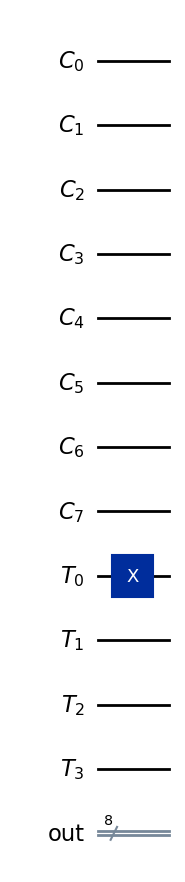

In [162]:
# Побудова квантової схеми Шора

control = QuantumRegister(num_control, name="C") # Керуючий регістр (для фазової оцінки)
target = QuantumRegister(num_target, name="T") # Цільовий регістр (для модульної експоненти)
output = ClassicalRegister(num_control, name="out") # Класичний регістр для вимірювань
circuit = QuantumCircuit(control, target, output)

# Ініціалізуємо target-регістр у стан |1>
circuit.x(target[0])
circuit.draw("mpl", fold=-1)

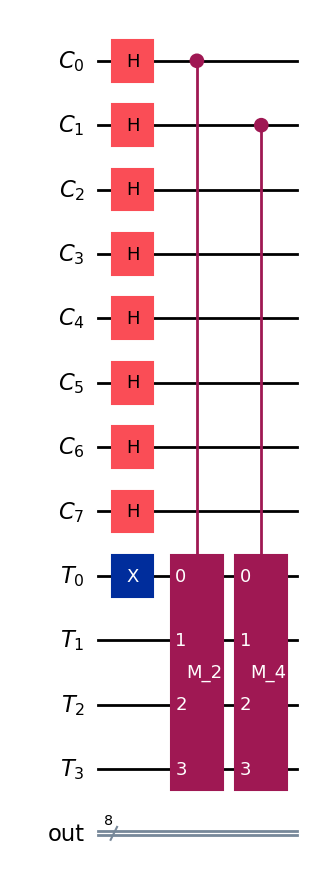

In [163]:
# Суперпозиція + контрольовані унітарні оператори
for k, qubit in enumerate(control):
    circuit.h(k)  # Переводимо керуючі кубіти у стан |+>
    b = b_list[k]  # Вибір відповідного оператора множення
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  
circuit.draw("mpl", fold=-1)


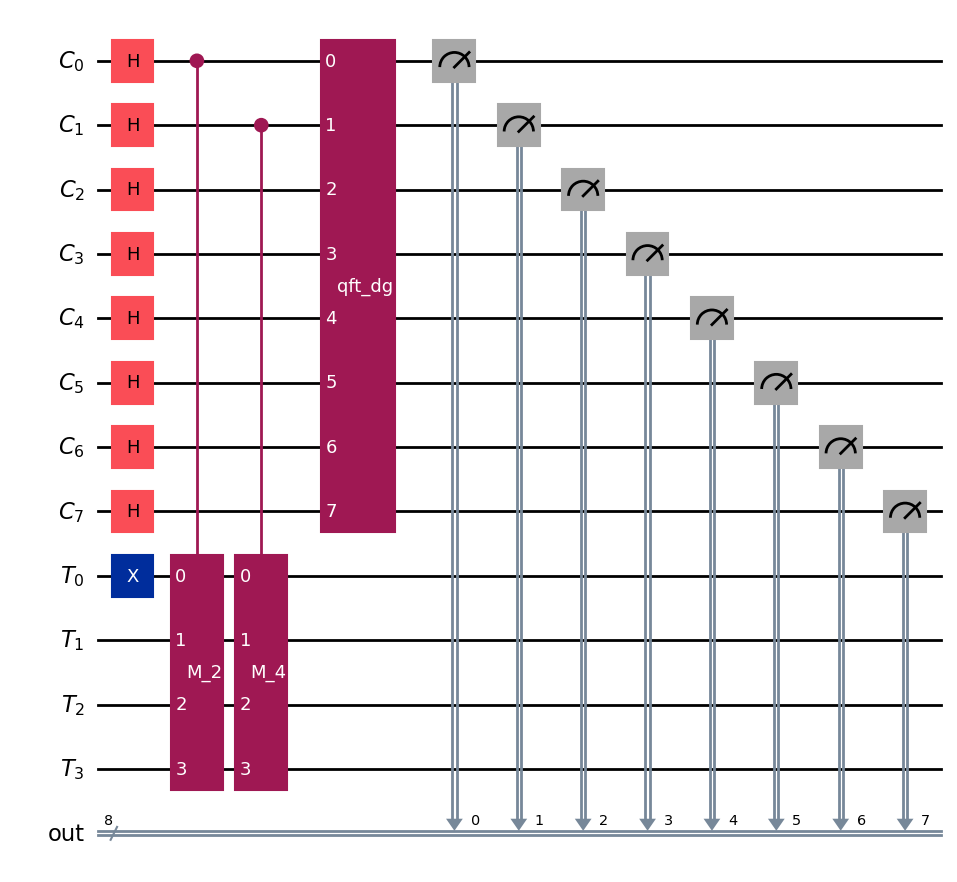

In [164]:
# Обернене квантове перетворення Фур'є
circuit.compose(QFTGate(num_control).inverse(), qubits=control, inplace=True)

# Вимірюємо лише керуючий регістр
circuit.measure(control, output)
circuit.draw("mpl", fold=-1)

Результати вимірювання: {'00000000': 272, '10000000': 252, '01000000': 259, '11000000': 241}


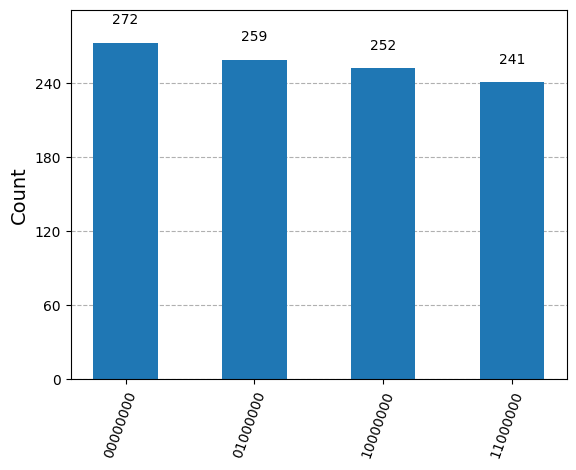

In [165]:
# Декомпозиція та транспіляція
circuit = circuit.decompose(reps=3)

sim = Aer.get_backend('aer_simulator')
tcircuit = transpile(circuit, sim)


result = sim.run(tcircuit, shots=1024).result()
counts = result.get_counts()
print("Результати вимірювання:", counts)
plot_histogram(counts)